# Predicting Game Newsletter Subscriptions Using Player Playtime and Experience Level Data

In [11]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)
library(ggplot2)
set.seed(1)

# 1. Introduction

## 1.1 Background Information

A research video game server created by Frank Wood and his research team at UBC aimed to collect data both in game about participant gameplay sessions, as well as external participant traits. A survey was taken by research participants prior to their playing sessions and this data has been collected into the players.csv file. 

## 1.2 Questions

#### ***Broad question:*** 
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

#### ***Specific question:*** 
Can experience level and play time predict subscription status to a game-related newsletter in the players.csv dataset? 



## 1.3 Dataset description
The dataset 'players.csv' describes 196 unique players, including data about each player.
Numbers of observations: 196,
numbers of variables: 7

|Variable     |   Type    |     Description  |
|-------------|-----------|------------------------------|
|experience   | Character |Player's experience level|
|hashedEmail  | Character |Player's ID|
|name         | Character |  Player's name               |
|gender       | Character  | Player's gender|
|played_hours | Double      |Player's playtime (in hours)|
|Age           |Double     | Player's age|
|subscribe     |Logical     |Whether the player subscribed to the newsletter|


Majority of the data was **collected** from players self-reporting when initially signing up for the server except for played_hours which was collected via the server recording activity of the players.
(source: https://plaicraft.ai/faq/ethics)

# 2. Methods & Results
## 2.1 Data Loading

In [12]:
players <- read_csv("https://raw.githubusercontent.com/JLin4115/gp_dsci_17/refs/heads/main/data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


## 2.2 Wrangling Data
The variable experience is originally stored as the character strings. To use it in classification models, we first convert it to a factor, and then convert the factor to numeric values. Also, we select only relevant variables (experience, playtime, and subscription) for the planned analysis. 

In [13]:
players_clean <- players |>
    mutate(experience = as.numeric(as.factor(experience))) |>
    select(experience, played_hours, subscribe)
players_clean

experience,played_hours,subscribe
<dbl>,<dbl>,<lgl>
3,30.3,TRUE
5,3.8,TRUE
5,0.0,FALSE
⋮,⋮,⋮
1,0.0,FALSE
1,2.3,FALSE
3,0.2,TRUE


|1|2|3|4|5|
|---|---|----|--|--|
|Amateur|Beginner|Pro|Regular|Veteran|

## 2.3 Summary Statistics

In [14]:
playersummary <- players_clean |>
    summarize(played_hours_mean = mean(played_hours, na.rm = TRUE),
              experience_mean = mean(experience, na.rm = TRUE),
             played_hours_min = min(played_hours, na.rm = TRUE),
             experience_min = min(experience, na.rm = TRUE),
              played_hours_max = max(played_hours, na.rm = TRUE),
              experience_max = max(experience, na.rm = TRUE))

playersummary

played_hours_mean,experience_mean,played_hours_min,experience_min,played_hours_max,experience_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.845918,2.852041,0,1,223.1,5


In a table:

|     |min|mean|max|
|----|-----|-------|----|
|played_hours|0.000|5.900|223.100|
|experience|1.000|2.852|5.000|

## 2.4 Exploratory Visualization
### 2.4.1 Experience vs Subscription Rate

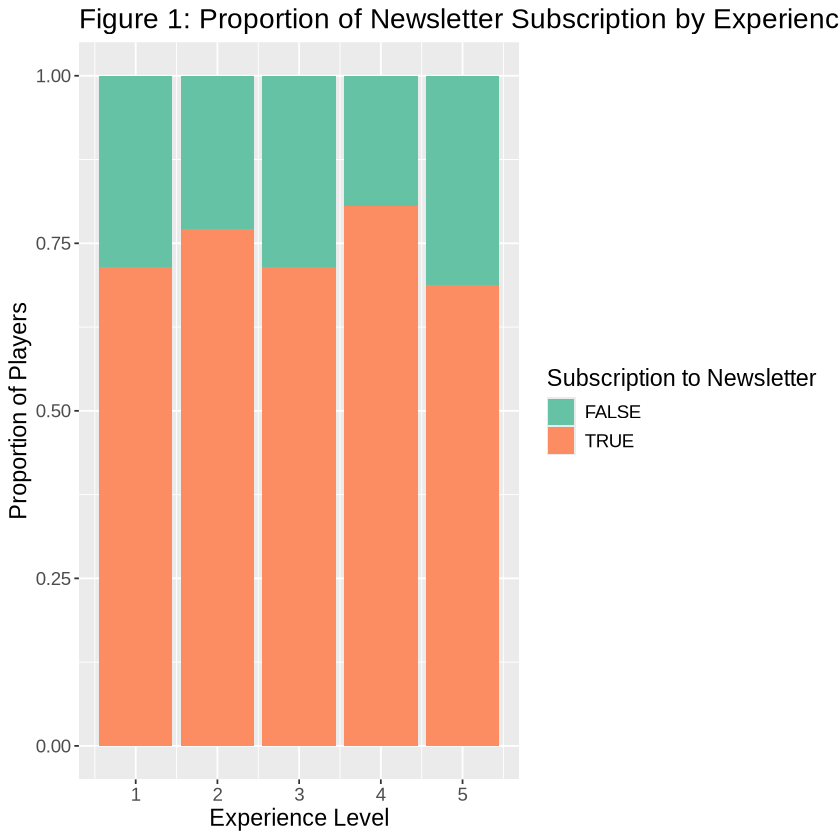

In [15]:
ggplot(players_clean, aes(x=experience, fill = subscribe)) +
    geom_bar(position="fill") +
    theme(text = element_text(size = 14)) +
    labs(title = "Figure 1: Proportion of Newsletter Subscription by Experience", x = "Experience Level", y = "Proportion of Players", fill = "Subscription to Newsletter") +
    scale_fill_brewer(palette = "Set2")

From Figure 1, it is apparent that there is a slight **class imbalance** in the 'subscribe' variable. 

Across the experience level, roughly 75%  of players are subscribed to a game-related newsletter. This means that a majority classifier that always guesses "TRUE" would have 75%~ accuracy. Ideally the classifier we build will have a higher accuracy.

### 2.4.2 Played hours by subscription status

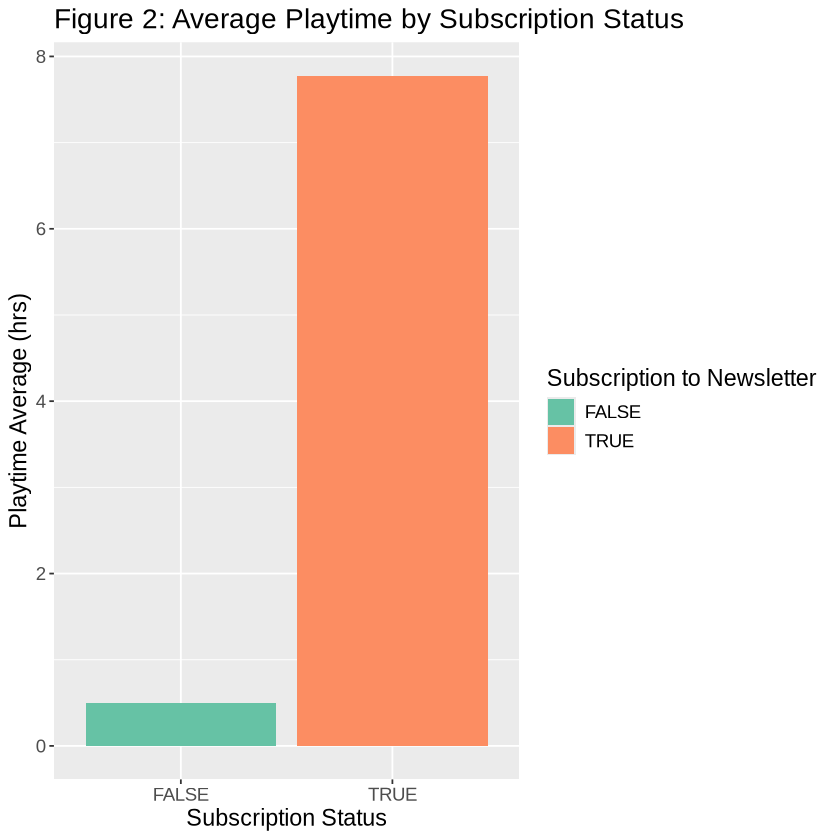

In [16]:
players_count <- players_clean |>
    group_by(subscribe) |>
    summarize(played_hours_average = mean(played_hours))

ggplot(players_count, aes(x=subscribe, y = played_hours_average, fill = subscribe)) +
    geom_bar(stat = "identity") +
    theme(text = element_text(size = 14)) +
    labs(title = "Figure 2: Average Playtime by Subscription Status", x = "Subscription Status", y = "Playtime Average (hrs)", fill = "Subscription to Newsletter") +
    scale_fill_brewer(palette = "Set2")

From figure 2 it can be observed that players subscribed to the newsletter played more hours on average (approximately 8x difference).



### 2.4.3 Played Hours by Experience level

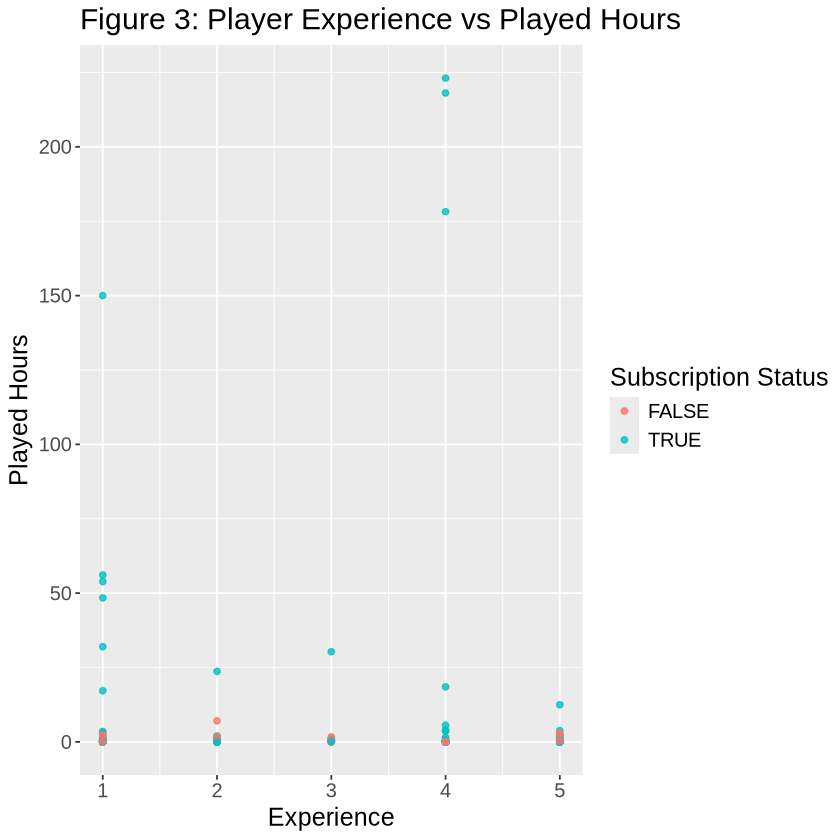

In [17]:
ggplot(players_clean, aes(x = experience, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.8) +
    theme(text = element_text(size = 15)) +
    labs(title = "Figure 3: Player Experience vs Played Hours", x = "Experience", y = "Played Hours", color = "Subscription Status")

## 2.5 Predictive Data Analysis

In [18]:
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 2))

players_knn <- players_clean |>
  mutate(subscribe = as_factor(subscribe))  

# Making Initial Split
players_split <- initial_split(players_knn, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing  <- testing(players_split)

# Training data using cross validation
players_recipe <- recipe(subscribe ~ experience + played_hours, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


knn_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)


knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

# Finding best K
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

best_k <- accuracies |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

# Predicting on test data
players_recipe_final <- recipe(subscribe ~ experience + played_hours, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knnspec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe_final) |>
  add_model(knnspec_final) |>
  fit(data = players_training)


players_test_predictions <- predict(knn_fit, players_testing) |>
  bind_cols(players_testing)

# Evaluating tuned model accuracy
players_test_accuracy <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4889163,5,0.03178632,Preprocessor1_Model01
3,accuracy,binary,0.5027094,5,0.04558752,Preprocessor1_Model02
5,accuracy,binary,0.4889163,5,0.04095164,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21,accuracy,binary,0.7348276,5,0.004190282,Preprocessor1_Model11
23,accuracy,binary,0.7348276,5,0.004190282,Preprocessor1_Model12
25,accuracy,binary,0.7348276,5,0.004190282,Preprocessor1_Model13


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


# 3. Discussion

# 4. References

https://plaicraft.ai/faq/ethics